**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [3]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='minkowski'):
        self.n_neighbors=n_neighbors
        self.algorithm=algorithm
        self.metric = metric
        return
    
    def fit(self, X, y):
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X, metric='minkowski', p=2.)
        self.X_train = X
        self.y_train = y
        return
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0]).astype(int)
        if self.algorithm == 'kd_tree':
            Dist, Arg = self.tree.query(X, k=self.n_neighbors)
            Weight = 1 / (1 + Dist)
            Class = np.take_along_axis(np.repeat(self.y_train[np.newaxis,:], y_pred.size, axis=0).reshape(y_pred.size, -1), Arg, axis=1)
        elif self.algorithm == 'brute':
            if self.metric == 'cosine':
                Dist = pairwise_distances(X, self.X_train, metric=self.metric)
                Arg = np.argsort(Dist, axis=1)[:, :self.n_neighbors]
                Weight = 1 / (1 + np.take_along_axis(Dist, Arg, axis=1))
            else:
                Dist = distance.cdist(X, self.X_train, metric=self.metric)
                Arg = np.argsort(Dist, axis=1)[:, :self.n_neighbors]
                Weight = 1 / (1 + np.take_along_axis(Dist, Arg, axis=1))
            Class = np.take_along_axis(np.repeat(self.y_train[np.newaxis,:], y_pred.size, axis=0).reshape(y_pred.size, -1), Arg, axis=1)
        Unique_classes = np.unique(Class)
        for i in range(Weight.shape[0]):
            mx = 0
            arg_mx = 0
            for c in Unique_classes:  
                cur_weight = ((Class[i] == c) * Weight[i]).sum()
                if cur_weight > mx:
                    mx = cur_weight
                    arg_mx = c
            y_pred[i] = arg_mx
        return y_pred
            
    
                
            
            
            
        
        
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute', metric='minkowski')

In [11]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [12]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
print(my_clf_pred)
print(sklearn_pred)
print(y_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

[0 0 2 1 2 2 2 0 1 1 1 0 2 2 0]
[0 0 2 1 2 2 2 0 1 1 1 0 2 2 0]
[0 0 2 1 2 2 2 0 1 1 1 0 2 1 0]


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [16]:
%%timeit
clf.fit(X_train, y_train)

140 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%%timeit
my_clf.fit(X_train, y_train)

154 ns ± 4.19 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [18]:
%%timeit
clf.predict(X_test)

713 µs ± 8.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%%timeit
my_clf.predict(X_test)

617 µs ± 4.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%%timeit
clf.fit(X_train, y_train)

253 µs ± 2.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%%timeit
my_clf.fit(X_train, y_train)

57.9 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%%timeit
clf.predict(X_test)

685 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%%timeit
my_clf.predict(X_test)

314 µs ± 5.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
print(my_clf_pred)
print(sklearn_pred)
print(y_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

[2 1 1 2 0 2 1 2 0 2 0 1 2 0 0]
[2 1 1 2 0 2 1 2 0 2 0 1 2 0 0]
[2 1 1 2 0 2 1 2 0 1 0 1 2 0 0]


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [21]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [22]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [5]:
vectorizer = CountVectorizer(min_df=0.003, max_df=0.15)
X = vectorizer.fit_transform(data).toarray()
X.shape

(11314, 4001)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [6]:
%%time

#Моя реализация

my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_score = cross_val_score(my_clf, X, target, cv=3, scoring='accuracy')

print(my_score)

[0.26378579 0.25457438 0.26491647]
Wall time: 5min 52s


In [6]:
%%time

#Реализация Sklearn

clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
sklearn_score = cross_val_score(clf, X, target, cv=3, scoring='accuracy')

print(sklearn_score)

[0.22985154 0.22566958 0.23097322]
Wall time: 7min 43s


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [8]:
mean_score = np.zeros(13)
for i in range(1, 26, 2):
    my_clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    mean_score[(i - 1) // 2] = cross_val_score(my_clf, X, target, cv=3, scoring='accuracy').mean()

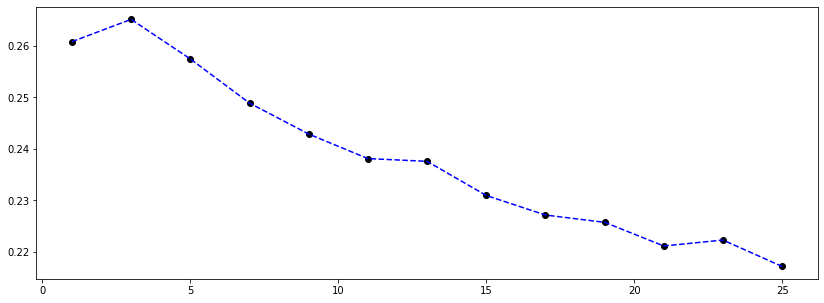

In [9]:
fig = plt.figure(figsize= (14,5))
plt.plot(np.arange(1, 26, 2), mean_score, 'b--')
plt.scatter(np.arange(1, 26, 2), mean_score, color='k')

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Качество существенно улучшилось, векторизация Tfidf лучше подходит для векторизации текстов, чем обычный CountVectorizer, 
так как Tfidf учитывает не просто сколько раз встретилось слово, а его "важность" в данном тексте.
Также косинусная метрика эффективней евклидовой для текстов, так как она намного лучше работает на разреженных векторах.


In [7]:
%%time

#Моя реализация

vectorizer = TfidfVectorizer(min_df=0.003, max_df=0.15)
X = vectorizer.fit_transform(data).toarray()
my_clf = MyKNeighborsClassifier(n_neighbors=2, metric='cosine')
my_score = cross_val_score(my_clf, X, target, cv=3, scoring='accuracy')

print(my_score)

[0.51882291 0.5202864  0.52399894]
Wall time: 12.8 s


In [8]:
%%time

#Реализация Sklearn

clf = KNeighborsClassifier(n_neighbors=2, metric='cosine')
sklearn_score = cross_val_score(clf, X, target, cv=3, scoring='accuracy')

print(sklearn_score)

[0.49681866 0.49058605 0.49323787]
Wall time: 8.74 s


In [67]:
vectorizer = TfidfVectorizer(min_df=0.003, max_df=0.15)
X = vectorizer.fit_transform(data).toarray()
mean_score_cosine = np.zeros(38)
for i in range(1, 76, 2):
    my_clf = MyKNeighborsClassifier(n_neighbors=i, metric='cosine')
    mean_score_cosine[(i - 1) // 2] = cross_val_score(my_clf, X, target, cv=3, scoring='accuracy').mean()

69


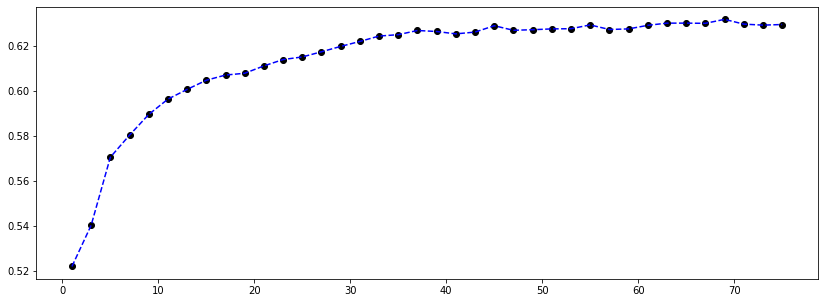

In [71]:
fig = plt.figure(figsize= (14,5))
plt.plot(np.arange(1, 76, 2), mean_score_cosine, 'b--')
plt.scatter(np.arange(1, 76, 2), mean_score_cosine, color='k')
print(np.argmax(mean_score_cosine) * 2 + 1)

In [ ]:
Посмотрю мой результат лучшей модели на кросс-валидации.

In [23]:
vectorizer = TfidfVectorizer(max_df=0.15)
X = vectorizer.fit_transform(data).toarray()
my_clf = MyKNeighborsClassifier(n_neighbors=69, metric='cosine')
mean_score_cos = cross_val_score(my_clf, X, target, cv=3, scoring='accuracy').mean()
print(mean_score_cos)

0.6742095332474891


Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [72]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data_test = newsgroups_test['data']
target_test = newsgroups_test['target']

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [80]:
vectorizer = TfidfVectorizer(min_df=0, max_df=0.15)
X = vectorizer.fit_transform(data).toarray()
my_clf = MyKNeighborsClassifier(n_neighbors=69, algorithm='brute', metric='cosine')
my_clf.fit(X, target)

vectorizer_test = TfidfVectorizer(vocabulary=vectorizer.get_feature_names())
X_test = vectorizer_test.fit_transform(data_test).toarray()

my_pred = my_clf.predict(X_test)
print(accuracy_score(my_pred, target_test))


0.6399362719065321


Как мы видим, качество немного упало по сравнению с кросс-валидацией. Одна из причин этого состоит в том, 
что я подбирал оптимальное число соседей и ограничивал по частотности выборку именно так, чтобы получить на
кросс-валидации наибольшее качество, то есть буквально "подгонялся" под выборку. На лицо эффект переобучения модели.